<a href="https://colab.research.google.com/github/pNTubil/CALC-LD/blob/main/XLMRLARGEXP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch transformers scikit-learn pandas
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [4]:
##################################
# Necessary Imports
##################################
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import (
    XLMRobertaTokenizer,
    XLMRobertaForSequenceClassification,
    Trainer,
    TrainingArguments
)
os.environ["WANDB_DISABLED"] = "true"
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

##################################
# Load Preprocessed Train & Validation Dataset (Upload to Colab First)
##################################
from google.colab import files

# Upload preprocessed CSVs
uploaded = files.upload()

# Load datasets
train_df = pd.read_csv("/content/train_preprocessed10knew.csv")
val_df = pd.read_csv("/content/val_preprocessed10knew.csv")

##################################
# Load XLM-R Large Tokenizer
##################################
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')

##################################
# Define Custom Dataset Class
##################################
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encodings['input_ids'].squeeze(),
            'attention_mask': encodings['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

##################################
# Create Train & Validation Dataset
##################################
train_dataset = ReviewDataset(train_df['review'], train_df['label'], tokenizer)
val_dataset = ReviewDataset(val_df['review'], val_df['label'], tokenizer)

##################################
# Load Pretrained XLM-R Large Model
##################################
model = XLMRobertaForSequenceClassification.from_pretrained(
    'xlm-roberta-large',
    num_labels=2  # Binary classification (Ambiguous vs. Not Ambiguous)
)

##################################
# Define Evaluation Metrics
##################################
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

##################################
# Training Arguments Configuration
##################################
training_args = TrainingArguments(
    output_dir="./xlm-r_large_results",
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",
    logging_dir="./logs_xlmr_large",
    logging_steps=50,
    per_device_train_batch_size=4,  # Increase batch size if GPU allows
    per_device_eval_batch_size=4,
    num_train_epochs=10,  # Changed to 10 epochs
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=True,  # Mixed precision training
    gradient_accumulation_steps=8,  # Adjust if memory issues occur
    load_best_model_at_end=True
)

##################################
# Initialize Trainer
##################################
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

##################################
# Train the Model
##################################
trainer.train()

##################################
# Save the Best Model
##################################
trainer.save_model("/content/xlm-r_large_results/best_model")
print("✅ Training complete. Best model saved to '/content/xlm-r_large_results/best_model'")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.372900,0.484970,0.845172,0.861741,0.845172,0.843394
2,0.133500,0.115947,0.970471,0.971480,0.970471,0.970454
3,0.092300,0.110426,0.978452,0.978804,0.978452,0.978448
4,0.048900,0.059974,0.987231,0.987409,0.987231,0.987229
5,0.021700,0.067091,0.988029,0.988090,0.988029,0.988028
6,0.031800,0.048115,0.990423,0.990603,0.990423,0.990422
7,0.017800,0.057421,0.988827,0.988872,0.988827,0.988827
8,0.005600,0.075032,0.988827,0.988951,0.988827,0.988826
9,0.000500,0.068401,0.991221,0.991232,0.991221,0.991221


✅ Training complete. Best model saved to '/content/xlm-r_large_results/best_model'


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Precision: 1.0000
F1-Score: 0.9903
ROC-AUC: 0.9979


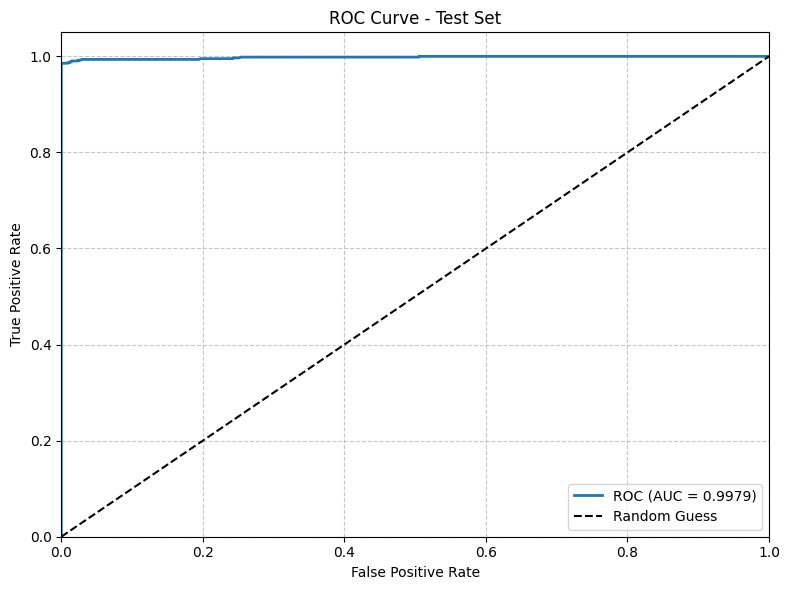

In [5]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

############################################
# 1. Load Test Data                        #
############################################

test_df = pd.read_csv('/content/test_preprocessed10knew.csv')

# Load tokenizer (adjust to your tokenizer path/name)
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')

############################################
# 2. Dataset Class                         #
############################################

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encodings['input_ids'].squeeze()
        attention_mask = encodings['attention_mask'].squeeze()
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

test_dataset = ReviewDataset(val_df['review'], val_df['label'], tokenizer)

############################################
# 3. Compute Metrics & Plotting Functions  #
############################################

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits_tensor = torch.tensor(logits)
    predictions = torch.argmax(logits_tensor, dim=1).numpy()
    probs = torch.nn.functional.softmax(logits_tensor, dim=1)[:, 1].numpy()

    # Compute metrics
    precision, _, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    roc_auc = roc_auc_score(labels, probs)

    return {
        "precision": precision,
        "f1": f1,
        "roc_auc": roc_auc
    }

def plot_roc_curve(labels, probs, title):
    fpr, tpr, _ = roc_curve(labels, probs)
    auc_score = roc_auc_score(labels, probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {auc_score:.4f})", linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

############################################
# 4. Load Trained (Best) Model             #
############################################

best_model_path = "/content/xlm-r_large_results/best_model"
model = XLMRobertaForSequenceClassification.from_pretrained(best_model_path, num_labels=2)

training_args = TrainingArguments(
    output_dir="/content/xlm-r_large_results",
    per_device_eval_batch_size=8,
    logging_dir="/content/logs_xlmr_large"
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=lambda eval_pred: compute_metrics(eval_pred)
)

############################################
# 5. Evaluate on Test Set                  #
############################################

test_results = trainer.predict(test_dataset=test_dataset)
metrics = compute_metrics((test_results.predictions, test_results.label_ids))

# Print selected metrics
print(f"Precision: {metrics['precision']:.4f}")
print(f"F1-Score: {metrics['f1']:.4f}")
print(f"ROC-AUC: {metrics['roc_auc']:.4f}")

# Plot ROC curve
probs = torch.nn.functional.softmax(
    torch.tensor(test_results.predictions), dim=1
)[:, 1].numpy()
plot_roc_curve(test_results.label_ids, probs, "ROC Curve - Test Set")